# Evasive PDF Samples

Based on https://www.kaggle.com/datasets/fouadtrad2/evasive-pdf-samples

### 1.1. What's the content of the dataset? 

This dataset is a collection of evasive PDF samples, labeled as malicious (1) or benign (0). Since the dataset has an evasive nature, it can be used to test the robustness of trained PDF malware classifiers against evasion attacks. The dataset contains 500,000 generated evasive samples, including 450,000 malicious and 50,000 benign PDFs. 

### 1.2. Dataset columns explanation 

1. **pdfsize** - The PDF size in Megabytes
2. **pages** - Pages
3. **title characters** - The number of characters in the title
4. **Images** - The number of images
5. **obj** - The number of keywords /obj
6. **endobj** - The number of keywords /endobj
7. **stream** - The number of keywords /stream
8. **endstream** - The number of keywords /endstream
9. **xref** - The number of xref tables
10. **trailer** - The number of keywords /trailer
11. **startxref** - The number of keywords /startxref
12. **ObjStm** - The number of keywords /Objstm (Object Streams)
13. **JS** - The number of keywords /JS
14. **OBS_JS** - The number of keywords /JS (obfuscated)
15. **Javascript** - The number of keywords /Javascript
16. **OBS_Javascript** - The number of keywords /Javascript (obfuscated)
17. **OpenAction** - The number of keywords /OpenAction
18. **OBS_OpenAction** - The number of keywords /OpenAction (obfuscated)
19. **Acroform** - The number of keywords /Acroform
20. **OBS_Acroform** - The number of keywords /Acroform (obfuscated)
21. **class** - Benign (0) or malicious (1)

### 1.3. ML models planned to use 

1. **Decision Tree** - Are relatively fast to train and can handle large datasets, which makes them suitable for this problem.
2. **K-Nearest Neighbours (KNN)** - Can handle non-linear data and does not make assumptions about the distribution of the data.
3. **Neural Networks** - Can be used for both classification and regression tasks, and can often achieve high levels of accuracy with appropriate training.

## 2. Imports the libraries

We start by importing the dependencies: Gymnasium, numpy, and random.

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
import seaborn as sb
import matplotlib.pyplot as plt


### 2.1. Define Helper Functions 

Here we'll find functions that calculate and get metrics about the dataset

In [2]:
def calculateMeanPageSize(sample):
    total_page_size = sum(pdf.pdfsize for pdf in sample)
    mean_page_size = total_page_size / len(sample)
    return int(mean_page_size)

In [3]:
def write_dataset(sample):
    data = {
        'nLines': [len(p)],
        'MeanPages': [calculateMeanPageSize(sample)]
    }
    df = pd.DataFrame(data)
    
    # Print the DataFrame
    print(df)

## 3. Importing datasets

In [4]:
sample = pd.read_csv('sample.csv')
print(f"There are {len(sample)} samples.")
sample.head()

There are 500000 samples.


,pdfsize,pages,title characters,images,obj,endobj,stream,endstream,xref,trailer,...,ObjStm,JS,OBS_JS,Javascript,OBS_Javascript,OpenAction,OBS_OpenAction,Acroform,OBS_Acroform,class
0,644.326,70,0,1,348,351,128,128,1,1,...,0,1,0,1,0,1,0,1,0,1
1,648.050,68,0,1,348,345,124,124,1,1,...,0,1,0,1,0,0,0,1,0,1
2,696.506,68,0,1,353,353,128,125,1,1,...,0,1,0,1,0,0,0,1,0,1
3,715.926,68,0,0,759,667,250,192,1,1,...,0,1,0,1,0,1,0,1,0,1
4,707.102,70,10,2,388,373,141,138,1,1,...,0,1,0,1,0,1,0,1,0,1


### 3.1. Column Datatypes

In [5]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pdfsize           500000 non-null  float64
 1   pages             500000 non-null  int64  
 2   title characters  500000 non-null  int64  
 3   images            500000 non-null  int64  
 4   obj               500000 non-null  int64  
 5   endobj            500000 non-null  int64  
 6   stream            500000 non-null  int64  
 7   endstream         500000 non-null  int64  
 8   xref              500000 non-null  int64  
 9   trailer           500000 non-null  int64  
 10  startxref         500000 non-null  int64  
 11  ObjStm            500000 non-null  int64  
 12  JS                500000 non-null  int64  
 13  OBS_JS            500000 non-null  int64  
 14  Javascript        500000 non-null  int64  
 15  OBS_Javascript    500000 non-null  int64  
 16  OpenAction        50

Seeing the output table, we can check that our dataset is composed by 20 attributes (columns) and it is visible that every column are numerical features ( all `int64` besides the pdfsize attribute's that are represented by `float64`. As we can see above, the dataset does not contain null values.

In [6]:
sample.shape

(500000, 21)

### 3.2. Data descripton

In [7]:
sample.describe()

,pdfsize,pages,title characters,images,obj,endobj,stream,endstream,xref,trailer,...,ObjStm,JS,OBS_JS,Javascript,OBS_Javascript,OpenAction,OBS_OpenAction,Acroform,OBS_Acroform,class
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.000000,500000.000000,500000.0,500000.000000,500000.0,500000.000000,500000.0,500000.000000,500000.0,500000.0
mean,563.363772,55.101686,5.617004,1.041594,273.595072,273.472290,95.115512,95.331500,0.969714,1.001358,...,0.008572,0.873134,0.0,0.795662,0.0,0.436600,0.0,0.887564,0.0,0.9
std,280.213763,30.233062,6.501397,0.734654,142.333280,142.734185,51.683914,52.094421,0.263349,0.244811,...,0.198168,0.547981,0.0,0.416932,0.0,0.495965,0.0,0.519314,0.0,0.3
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,585.864250,67.000000,0.000000,1.000000,266.000000,266.000000,85.000000,87.000000,1.000000,1.000000,...,0.000000,1.000000,0.0,1.000000,0.0,0.000000,0.0,1.000000,0.0,1.0
50%,657.841000,68.000000,4.000000,1.000000,346.000000,345.000000,123.000000,122.000000,1.000000,1.000000,...,0.000000,1.000000,0.0,1.000000,0.0,0.000000,0.0,1.000000,0.0,1.0
75%,708.503250,69.000000,9.000000,2.000000,355.000000,354.000000,126.000000,126.000000,1.000000,1.000000,...,0.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.0
max,1761.042000,287.000000,267.000000,18.000000,760.000000,760.000000,254.000000,254.000000,3.000000,3.000000,...,15.000000,3.000000,0.0,5.000000,0.0,1.000000,0.0,2.000000,0.0,1.0


- The **count** row shows the number of non-null entries in each column of the dataset.
- The **mean** rows the average value of each column.
- The **std** shows the standard deviation of each column, displaying how much the values deviate from the mean.
- The **25%**, **50%** and **75%** rows show the first quartile, the median quartile and the third quartile values for each column.
- The **min** and **max** rows show the minimum and maximum values in each column.

In [8]:
sample['class'].value_counts()

class
1    450000
0     50000
Name: count, dtype: int64

/var/folders/0_/_8ntzlm570v_s7fd44s105yc0000gn/T/ipykernel_7409/107236906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='class', data=sample, palette='hls')


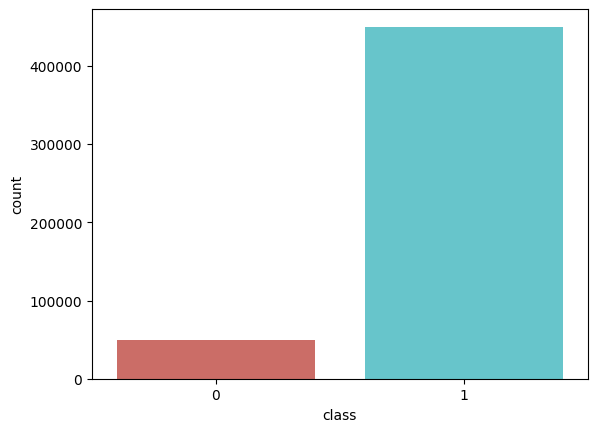

In [9]:
#create me a bar chart of the class column

sb.countplot(x='class', data=sample, palette='hls')
plt.show()

# 4. Data preprocessing 

We will need to preprocess the dataset received in order to model it.

In [ ]:
datasets = {} # dictionary to store the pre-processing datasets

Below, we can see that our dataset is unbalenced because there is a significant difference between the values of the binary feature ('class' column). There are 50000 0's (or no's) and 450000 1's (or yes's). <br />
To balance our dataset, we will use **Synthetic Minority Over-sampling Technique (SMOTE)** for oversampling and **RandomUnderSampler** for undersampling.

In [11]:
print("Values of the feature column ('class')")
sample['class'].value_counts()

Values of the feature column ('class')


class
1    450000
0     50000
Name: count, dtype: int64

### 4.1. Undersampling 

In [16]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X = sample.drop('class', axis=1)
y = sample['class']
X_res_undersampling, y_res_undersampling = rus.fit_resample(X, y)
print("Values of the feature column ('class') after undersampling")
y_res_undersampling.value_counts()

Values of the feature column ('class') after undersampling


class
0    50000
1    50000
Name: count, dtype: int64

As you can see in the result output, we now have an undersampled balanced dataset because we have similar numbers of no's and yes's (0's and 1's, respectively). 

### 4.2. Oversampling

In [22]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res_overslampling, y_res_oversampling = smote.fit_resample(X, y)
print("Values of the feature column ('class') after oversampling")
y_res_oversampling.value_counts()


Values of the feature column ('class') after oversampling


class
1    450000
0    450000
Name: count, dtype: int64

As you can see in the result output, we now have an oversampled balanced dataset because we have similar numbers of no's and yes's (0's and 1's, respectively). 